To make the model even more complex we will:
1) Add a Convolutional layer followed by a batch normalization, relu and a dropout2d layer.
2) Add residual (skip) blocks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import json, re
import pandas as pd
import importlib, sys, os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.optim as optim # for PyTorch optimizers
import math
from torch.utils.data import Subset, ConcatDataset
import os, random, numpy as np
from torchvision import transforms, datasets 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


SEED = 42

# Python and NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)


# Apple Silicon (MPS) - safe to call regardless of MPS availability
if hasattr(torch, "mps") and torch.backends.mps.is_available():
    torch.manual_seed(SEED)

# Deterministic behavior (may reduce speed; some ops may still be nondeterministic)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False





class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, drop_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.drop = nn.Dropout2d(drop_p) if drop_p and drop_p > 0 else nn.Identity()

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.drop(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)
        return out


In [3]:
class ResCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # keep 16 channels, same spatial size
        self.stage1 = nn.Sequential(
            BasicBlock(16, 16, stride=1, drop_p=0.0),
            BasicBlock(16, 16, stride=1, drop_p=0.0),
        )

        # go 16 -> 32 and downsample (stride=2 does both, with projection)
        self.stage2 = nn.Sequential(
            BasicBlock(16, 32, stride=2, drop_p=0.1),
            BasicBlock(32, 32, stride=1, drop_p=0.1),
        )

        # go 32 -> 64 and downsample again
        self.stage3 = nn.Sequential(
            BasicBlock(32, 64, stride=2, drop_p=0.2),
            BasicBlock(64, 64, stride=1, drop_p=0.2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.LazyLinear(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.classifier(x)
        return x


In [4]:
# Load datasets 

img_size = (256, 256)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(
        brightness = 0.2,
        saturation = 0.2,
        contrast = 0.2,
        hue = 0.1,
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


train_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
val_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val", transform=train_transform)

full_ds = ConcatDataset([train_ds_local, val_ds_local])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indices = np.arange(len(full_ds))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
history = {
    "fold": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

fold_summary = []  # one row per fold (e.g., best/last metrics)

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f'Fold {fold + 1}')
    train_subset = Subset(full_ds, train_idx)
    val_subset   = Subset(full_ds, val_idx)

    cnn = ResCNN()
    cnn = cnn.to(device) # moves model parameters (weights and biases) to the target device


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.0005115859153484923, momentum = 0.9)

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size = 16,
        shuffle = True,
        num_workers = 0,
    )
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size = 16,
        shuffle = False,
        num_workers = 0,
    )

    best_val_loss = math.inf
    best_val_acc = 0.0

    for epoch in range(20):

        print(f'Training epoch {epoch}...')
        cnn.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        n_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(inputs)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            n_train += labels.size(0)

        train_loss = running_loss / max(n_train, 1)
        train_acc  = train_correct / max(train_total, 1)
        
        print(f'Loss = {round(train_loss, 4)}, Accuracy = {round(train_acc, 4)}')

        cnn.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cnn(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / max(total, 1)
        val_acc = correct / max(total, 1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        history["fold"].append(fold + 1)
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)


        print(f'Validation accuracy: {val_acc}')
    
    fold_summary.append({
    "fold": fold + 1,
    "best_val_loss": best_val_loss,
    "best_val_acc": best_val_acc,
    "last_val_loss": val_loss,
    "last_val_acc": val_acc,
        })

Fold 1
Training epoch 0...
Loss = 1.1487, Accuracy = 0.3892
Validation accuracy: 0.47580645161290325
Training epoch 1...
Loss = 0.9085, Accuracy = 0.5495
Validation accuracy: 0.7123655913978495
Training epoch 2...
Loss = 0.6526, Accuracy = 0.6848
Validation accuracy: 0.8682795698924731
Training epoch 3...
Loss = 0.5282, Accuracy = 0.7724
Validation accuracy: 0.8817204301075269
Training epoch 4...
Loss = 0.4349, Accuracy = 0.8189
Validation accuracy: 0.8978494623655914
Training epoch 5...
Loss = 0.4068, Accuracy = 0.8263
Validation accuracy: 0.9408602150537635
Training epoch 6...
Loss = 0.3429, Accuracy = 0.864
Validation accuracy: 0.9354838709677419
Training epoch 7...
Loss = 0.3003, Accuracy = 0.8862
Validation accuracy: 0.9301075268817204
Training epoch 8...
Loss = 0.2351, Accuracy = 0.9057
Validation accuracy: 0.9650537634408602
Training epoch 9...
Loss = 0.206, Accuracy = 0.93
Validation accuracy: 0.9327956989247311
Training epoch 10...
Loss = 0.1927, Accuracy = 0.93
Validation acc

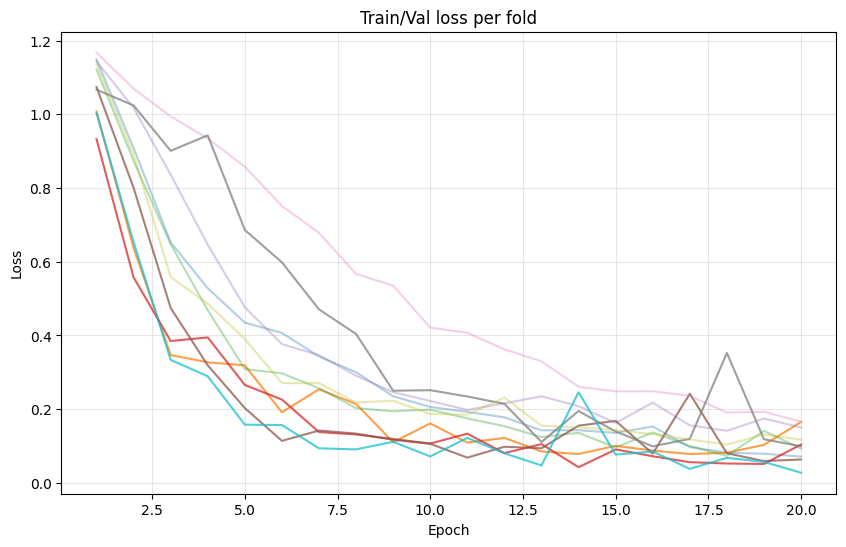

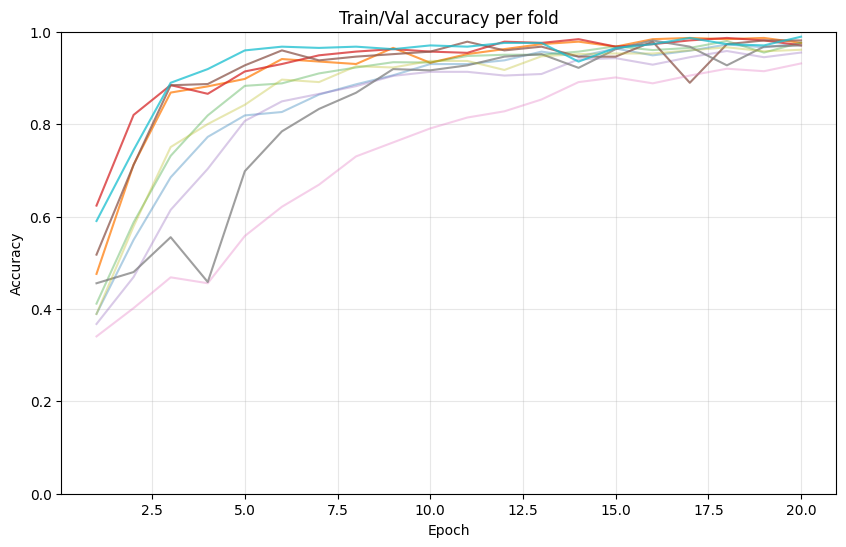

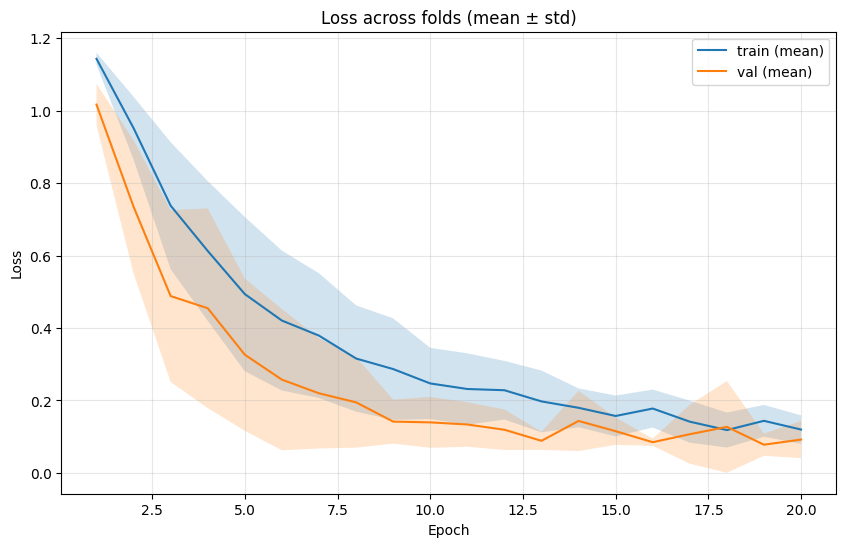

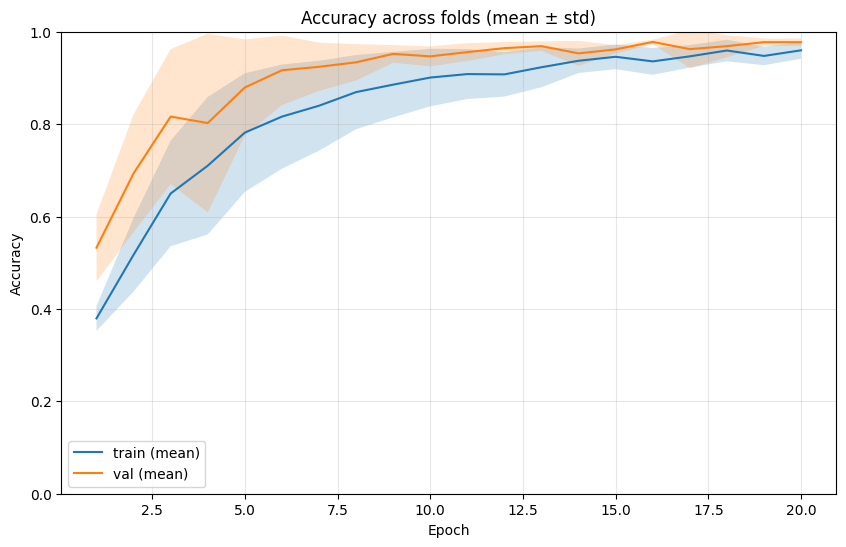

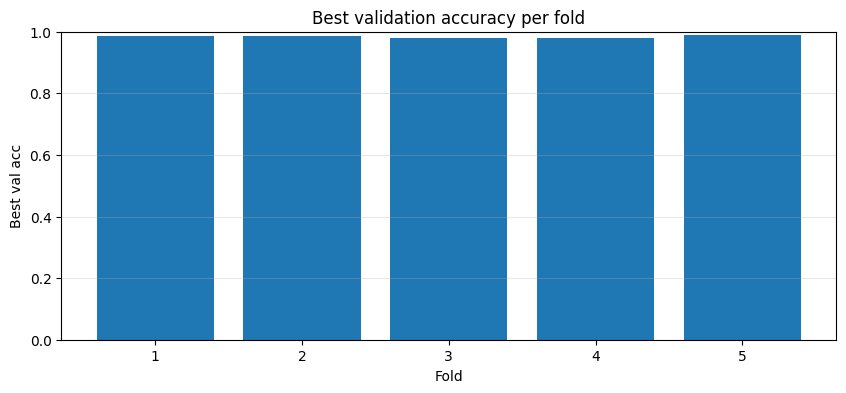

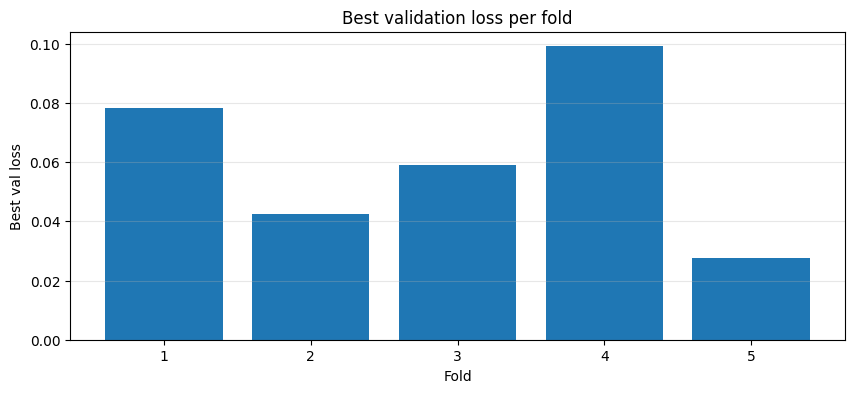

Best val acc: mean = 0.9849201518708519 std = 0.003624428701299123
Best val loss: mean = 0.06132765107281365 std = 0.028335164905669834


In [5]:

#  Convert to DataFrame
hist_df = pd.DataFrame(history)
summ_df = pd.DataFrame(fold_summary)

# Safety: ensure numeric
for c in ["fold", "epoch"]:
    hist_df[c] = hist_df[c].astype(int)

#Per-fold curves: Loss
plt.figure(figsize=(10, 6))
for fold in sorted(hist_df["fold"].unique()):
    d = hist_df[hist_df["fold"] == fold].sort_values("epoch")
    plt.plot(d["epoch"], d["train_loss"], alpha=0.35)
    plt.plot(d["epoch"], d["val_loss"],   alpha=0.75)
plt.title("Train/Val loss per fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# Per-fold curves: Accuracy 
plt.figure(figsize=(10, 6))
for fold in sorted(hist_df["fold"].unique()):
    d = hist_df[hist_df["fold"] == fold].sort_values("epoch")
    plt.plot(d["epoch"], d["train_acc"], alpha=0.35)
    plt.plot(d["epoch"], d["val_acc"],   alpha=0.75)
plt.title("Train/Val accuracy per fold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

# Mean ± std across folds per epoch
agg = (
    hist_df
    .groupby("epoch")
    .agg(
        train_loss_mean=("train_loss", "mean"),
        train_loss_std =("train_loss", "std"),
        val_loss_mean  =("val_loss", "mean"),
        val_loss_std   =("val_loss", "std"),
        train_acc_mean =("train_acc", "mean"),
        train_acc_std  =("train_acc", "std"),
        val_acc_mean   =("val_acc", "mean"),
        val_acc_std    =("val_acc", "std"),
    )
    .reset_index()
)

# Loss mean±std
plt.figure(figsize=(10, 6))
plt.plot(agg["epoch"], agg["train_loss_mean"], label="train (mean)")
plt.fill_between(
    agg["epoch"],
    agg["train_loss_mean"] - agg["train_loss_std"].fillna(0),
    agg["train_loss_mean"] + agg["train_loss_std"].fillna(0),
    alpha=0.2
)
plt.plot(agg["epoch"], agg["val_loss_mean"], label="val (mean)")
plt.fill_between(
    agg["epoch"],
    agg["val_loss_mean"] - agg["val_loss_std"].fillna(0),
    agg["val_loss_mean"] + agg["val_loss_std"].fillna(0),
    alpha=0.2
)
plt.title("Loss across folds (mean ± std)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Accuracy mean±std
plt.figure(figsize=(10, 6))
plt.plot(agg["epoch"], agg["train_acc_mean"], label="train (mean)")
plt.fill_between(
    agg["epoch"],
    agg["train_acc_mean"] - agg["train_acc_std"].fillna(0),
    agg["train_acc_mean"] + agg["train_acc_std"].fillna(0),
    alpha=0.2
)
plt.plot(agg["epoch"], agg["val_acc_mean"], label="val (mean)")
plt.fill_between(
    agg["epoch"],
    agg["val_acc_mean"] - agg["val_acc_std"].fillna(0),
    agg["val_acc_mean"] + agg["val_acc_std"].fillna(0),
    alpha=0.2
)
plt.title("Accuracy across folds (mean ± std)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- 4) Fold-level summary plots ----
# Best val acc per fold
plt.figure(figsize=(10, 4))
plt.bar(summ_df["fold"], summ_df["best_val_acc"])
plt.title("Best validation accuracy per fold")
plt.xlabel("Fold")
plt.ylabel("Best val acc")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Best val loss per fold
plt.figure(figsize=(10, 4))
plt.bar(summ_df["fold"], summ_df["best_val_loss"])
plt.title("Best validation loss per fold")
plt.xlabel("Fold")
plt.ylabel("Best val loss")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Optional: print a numeric summary
print("Best val acc: mean =", summ_df["best_val_acc"].mean(), "std =", summ_df["best_val_acc"].std())
print("Best val loss: mean =", summ_df["best_val_loss"].mean(), "std =", summ_df["best_val_loss"].std())

In [9]:
import matplotlib
print("matplotlib file:", matplotlib.__file__)
print("matplotlib version:", matplotlib.__version__)


matplotlib file: /Users/alessandro/Progetti/RockPaperScissorNew/.venv/lib/python3.9/site-packages/matplotlib/__init__.py
matplotlib version: 3.9.4


In [6]:

final_cnn = ResCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=0.0005115859153484923, momentum=0.9)

final_loader = torch.utils.data.DataLoader(full_ds, batch_size=16, shuffle=True, num_workers=2)

EPOCHS_FINAL = 20  # or pick based on CV curves

for epoch in range(EPOCHS_FINAL):
    final_cnn.train()
    for inputs, labels in final_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(final_cnn.state_dict(), "trained_res_cnn_final.pth")


In [7]:


TEST_DIR = "/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/test"  


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


img_size = (256, 256)
test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load test set
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transform)
print("Test classes:", test_ds.classes, "  n_test:", len(test_ds))


cnn = ResCNN().to(device)
cnn.load_state_dict(torch.load("trained_res_cnn_final.pth", map_location=device))
cnn.eval()


# Dataloader (you can use best batchsize or set your own)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
)

# Evaluate
criterion = nn.CrossEntropyLoss()
total, correct, test_loss_sum = 0, 0, 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = cnn(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        test_loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += bs

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_loss = test_loss_sum / max(total, 1)
test_acc = correct / max(total, 1)


print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test classes: ['paper', 'rock', 'scissors']   n_test: 331
Test loss: 0.0619
Test accuracy: 0.9879


Confusion matrix (counts):
 [[107   1   0]
 [  1 108   1]
 [  0   1 112]]


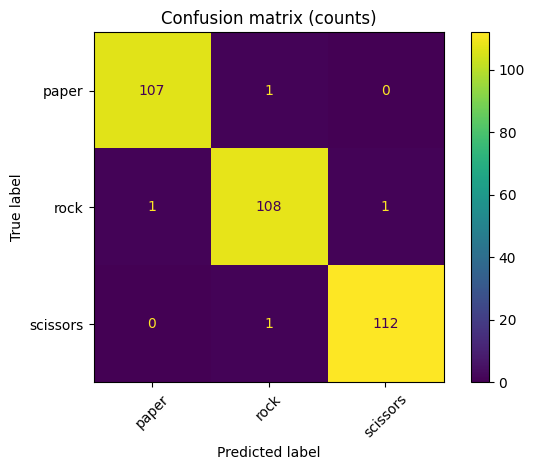

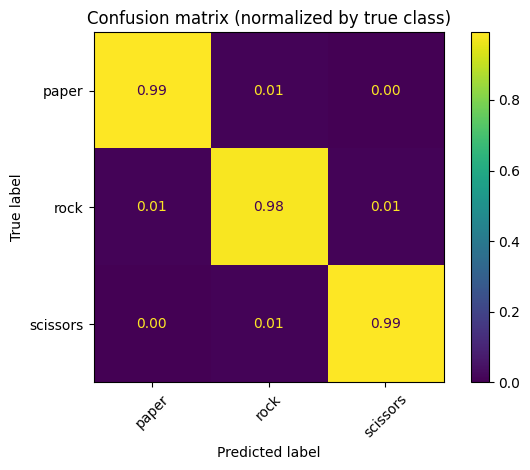


Classification report:
              precision    recall  f1-score   support

       paper     0.9907    0.9907    0.9907       108
        rock     0.9818    0.9818    0.9818       110
    scissors     0.9912    0.9912    0.9912       113

    accuracy                         0.9879       331
   macro avg     0.9879    0.9879    0.9879       331
weighted avg     0.9879    0.9879    0.9879       331



In [8]:
# Concatenate the tensors you collected during evaluation
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred)  # C[i, j] = # true=i predicted=j [web:20]
print("Confusion matrix (counts):\n", cm)

# Optional: normalized by true class (rows sum to 1)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")  # normalize='true' -> row-normalized [web:20]

# Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (counts)")
plt.tight_layout()
plt.show()  # ConfusionMatrixDisplay is intended for plotting a confusion matrix [web:27]

# Plot (row-normalized)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=test_ds.classes)
disp_norm.plot(xticks_rotation=45, values_format=".2f")
plt.title("Confusion matrix (normalized by true class)")
plt.tight_layout()
plt.show()  # normalize option controls how entries are normalized [web:27]

# Classification report (precision/recall/F1 per class)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))  # target_names labels classes [web:19]


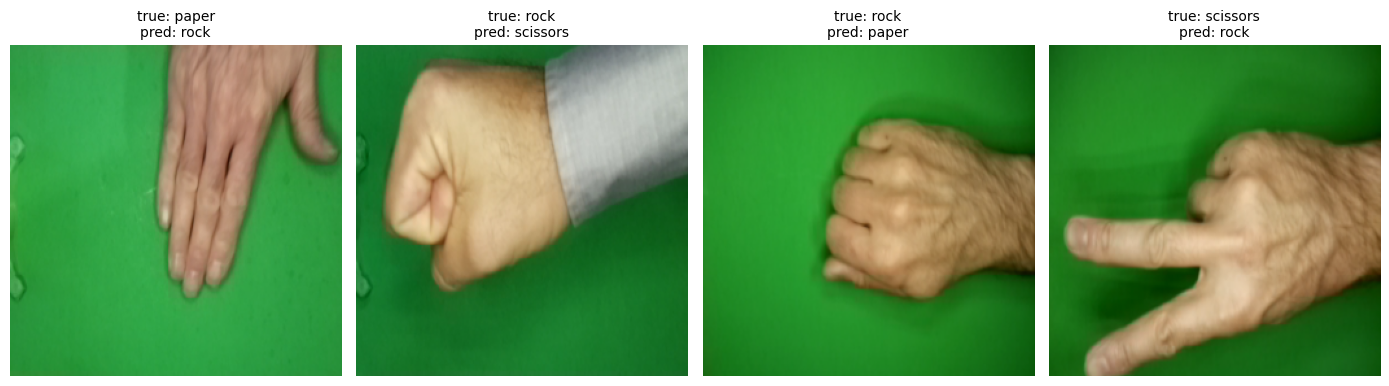

In [9]:
# helper: unnormalize for display (matches your Normalize(mean=0.5, std=0.5)) ----
def denorm(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # img: (C,H,W)
    mean = torch.tensor(mean).view(-1, 1, 1)
    std  = torch.tensor(std).view(-1, 1, 1)
    return img * std + mean

@torch.no_grad()
def collect_misclassified(model, loader, device, class_names, max_samples = None):
    model.eval()
    wrong = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        mis_mask = preds.ne(y)
        if mis_mask.any():
            xs = x[mis_mask].cpu()
            ys = y[mis_mask].cpu()
            ps = preds[mis_mask].cpu()

            for xi, yi, pi in zip(xs, ys, ps):
                wrong.append((xi, int(yi), int(pi)))
                if len(wrong) >= max_samples:
                    return wrong
    return wrong

def plot_misclassified(wrong, class_names, ncols=5, figsize=(14, 10)):
    if len(wrong) == 0:
        print("No misclassified images found.")
        return

    n = len(wrong)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.ravel() if n > 1 else [axes]

    for i, ax in enumerate(axes):
        if i >= n:
            ax.axis("off")
            continue

        img, y_true, y_pred = wrong[i]

        img = denorm(img).clamp(0, 1)          # back to [0,1]
        img = img.permute(1, 2, 0).numpy()     # HWC for matplotlib

        ax.imshow(img)
        ax.set_title(f"true: {class_names[y_true]}\npred: {class_names[y_pred]}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Usage with your objects from the notebook 
wrong = collect_misclassified(
    model=cnn,
    loader=test_loader,
    device=device,
    class_names=test_ds.classes,
    max_samples=25
)

plot_misclassified(wrong, class_names=test_ds.classes, ncols=5, figsize=(14, 10))
